# 나이브 베이스 분류기(Naive Bayes Classification)

* 베이즈 정리를 적용한 확률적 분류 알고리즘
* 모든 특성들이 독립임을 가정 (naive 가정)
* 입력 특성에 따라 3개의 분류기 존재
  * 가우시안 나이브 베이즈 분류기
  * 베르누이 나이브 베이즈 분류기
  * 다항 나이브 베이즈 분류기

## 나이브 베이즈 분류기의 확률 모델

* 나이브 베이즈는 조건부 확률 모델 가지고 만들어짐
* *N*개의 특성을 나타내는 벡터 **x**를 입력 받아 k개의 가능한 확률적 결과를 출력

\begin{equation}
p(C_k | x_1,...,x_n)
\end{equation}

* 위의 식에 베이즈 정리를 적용하면 다음과 같음

\begin{equation}
p(C_k | \textbf{x}) = \frac{p(C_k)p(\textbf{x}|C_k)}{p(\textbf{x})}
\end{equation}

* 위의 식에서 분자만이 출력 값에 영향을 받기 때문에 분모 부분을 상수로 취급할 수 있음

\begin{equation}
\begin{split}
p(C_k | \textbf{x}) & \propto p(C_k)p(\textbf{x}|C_k) \\
& \propto p(C_k, x_1, ..., x_n)
\end{split}
\end{equation}

* 위의 식을 연쇄 법칙을 사용해 다음과 같이 쓸 수 있음

\begin{equation}
\begin{split}
p(C_k, x_1, ..., x_n) & = p(C_k)p(x_1, ..., x_n | C_k) \\
& = p(C_k)p(x_1 | C_k)p(x_2, ..., x_n | C_k, x_1) \\
& = p(C_k)p(x_1 | C_k)p(x_2 | C_k, x_1)p(x_3, ..., x_n | C_k, x_1, x_2) \\
& = p(C_k)p(x_1 | C_k)p(x_2 | C_k, x_1)...p(x_n | C_k, x_1, x_2, ..., x_{n-1})
\end{split}
\end{equation}

* 나이브 베이즈 분류기는 모든 특성이 독립이라고 가정하기 때문에 위의 식을 다음과 같이 쓸 수 있음

\begin{equation}
\begin{split}
p(C_k, x_1, ..., x_n) & \propto p(C_k)p(x_1|C_k)p(x_2|C_k)...p(x_n|C_k) \\
& \propto p(C_k) \prod_{i=1}^{n} p(x_i|C_k)
\end{split}
\end{equation}

* 위의 식을 통해 나온 값들 중 가장 큰 값을 갖는 클래스가 예측 결과

\begin{equation}
\hat{y} = \underset{k}{\arg\max} \; p(C_k) \prod_{i=1}^{n} p(x_i|C_k)
\end{equation}

In [2]:
import numpy as np
import pandas as pd

from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.datasets import fetch_covtype,fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer,HashingVectorizer,TfidfVectorizer

# 나이브베이즈의 핵심 작동원리
 * 각 클래스에 대한 가능도 (likelihood) 비교를 통한 분류
 * 즉 likelihood에 대한 이해가 가장 핵심적
 * 사실상 베이즈 정리의 철학을 기반으로 작동하는 분류기

# 베이즈 정리 
 * 새로운 정보를 토대로 어떤 사건이 발생했다는 주자엥 대한 신뢰도를 갱신해 나가는 방법
 * 사전지식을 이용한 분류 prior :기존에 알고있던 확률
 * likelihood : 특정 정보가 추가되는경우 : 키 정보만으로 성별을 구분할경우
 확률분포에서 정보에 대한 가능성
 * likelihood는 추가 정보이기 때문에 기존에 알고 있던 사전 지식(PRIOR)에 추가 정보(likelihood)를 얹어주는 방식으로 판단근거를 찾는 것이 더욱 바람직함
 * 즉 판단근거 = 사전지식 * 추가정보
 * 수식으로 쓰면 
  - 남자라고 판단할 근거 :p(성별 =남자) * P(키 =175 |성별 =남자)
  - 여자라고 판단할 근거 :p(성별 =여자) * P(키 =175 |성별 =여자)

 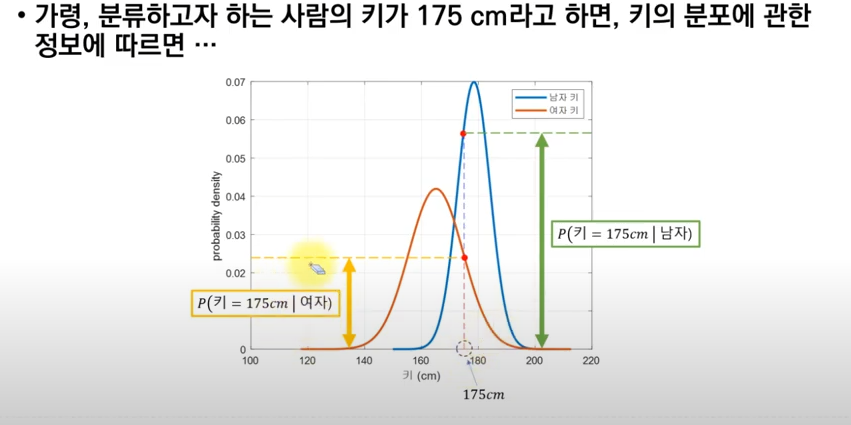
 

 * 가령 몸무게에 관한 정보가 추가된다면 사전정보에 추가 정보를 곱해주었던것 처럼 그 뒤에 계속 추가 정보를 덧 붙일수 있다. 
 * test data 사람의 몸무게가 80kg였다면 

  - 남자라고 판단할 근거 :p(성별 =남자) * P(키 =175 |성별 =남자) * p(몸무게 =80 |성별 =남자)
  - 여자라고 판단할 근거 :p(성별 =여자) * P(키 =175 |성별 =여자) * p(몸무게 =80 |성별 =여자)
  * 작동방식은 train 데이터에서 클래스별 비율을 계산하여 미리 사전확률을 계산함
  * 클래스별 feature의 분포를 추정한후 
  * prior 에 liklihood를 계속 곱해주어 가장 값이 큰 클로스로 분류됨

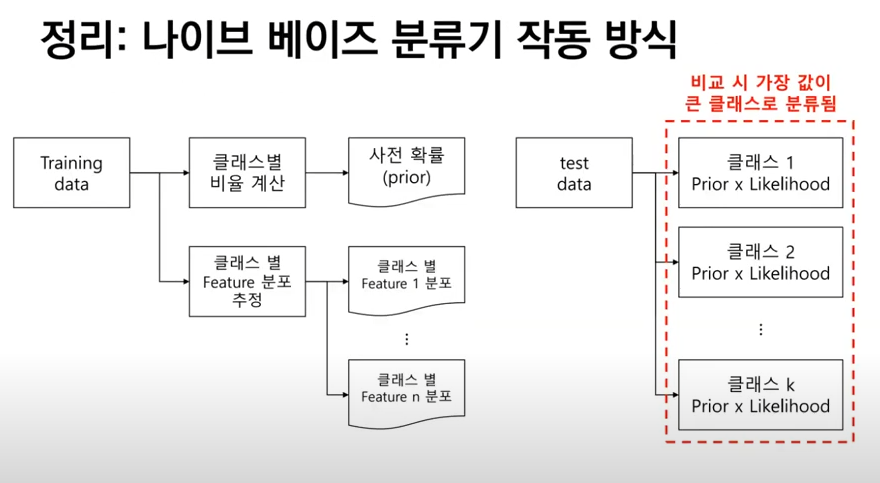

In [3]:
prior = [0.45,0.3,0.15,0.1]
likelihood = [[0.3,0.3,0.4],[0.7,0.2,0.1],[0.15,0.5,0.53],[0.6,0.02,0.2]]

#반복문을 돌면서 각각의 가능성 확률
idx = 0 
for c,xs in zip(prior,likelihood):
  result = 1 
  for x in xs:
    result *= x
  result *= c

  idx += 1
  print(f'{idx}번째 클래스의 가능성:{result}')

1번째 클래스의 가능성:0.0162
2번째 클래스의 가능성:0.0042
3번째 클래스의 가능성:0.0059625
4번째 클래스의 가능성:0.00024000000000000003


## 산림 토양 데이터
* 산림 지역 토양의 특징 데이터
* 토양이 어떤 종류에 속하는지 예측
* https://archive.ics.uci.edu/ml/datasets/Covertype 에서 데이터의 자세한 설명 확인 가능

In [4]:
covtype = fetch_covtype()

In [6]:
pd.DataFrame(covtype.data)

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
0,2596.0,51.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2590.0,56.0,2.0,212.0,-6.0,390.0,220.0,235.0,151.0,6225.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2804.0,139.0,9.0,268.0,65.0,3180.0,234.0,238.0,135.0,6121.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2785.0,155.0,18.0,242.0,118.0,3090.0,238.0,238.0,122.0,6211.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2595.0,45.0,2.0,153.0,-1.0,391.0,220.0,234.0,150.0,6172.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581007,2396.0,153.0,20.0,85.0,17.0,108.0,240.0,237.0,118.0,837.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
581008,2391.0,152.0,19.0,67.0,12.0,95.0,240.0,237.0,119.0,845.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
581009,2386.0,159.0,17.0,60.0,7.0,90.0,236.0,241.0,130.0,854.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
581010,2384.0,170.0,15.0,60.0,5.0,90.0,230.0,245.0,143.0,864.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
covtype.target  

array([5, 5, 2, ..., 3, 3, 3], dtype=int32)

### 학습, 평가 데이터 분류

In [9]:
covtype_X = covtype.data
covtype_y = covtype.target

In [10]:
covtype_X_train, covtype_X_test, covtype_y_train, covtype_y_test = train_test_split(covtype_X,covtype_y,test_size=0.2)

In [11]:
print('전체 데이터 크기 {}'.format(covtype_X.shape))
print('학습 데이터 크기 {}'.format(covtype_X_train.shape))
print('평가 데이터 크기 {}'.format(covtype_X_test.shape))

전체 데이터 크기 (581012, 54)
학습 데이터 크기 (464809, 54)
평가 데이터 크기 (116203, 54)


### 전처리

#### 전처리 전 데이터

In [14]:
covtype_df = pd.DataFrame(data=covtype_X_train)
covtype_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
count,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,...,464809.000000,464809.000000,464809.000000,464809.000000,464809.00000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000
mean,2959.281967,155.690697,14.108133,269.483033,46.458793,2349.328574,212.123694,223.316571,142.548539,1980.071098,...,0.044089,0.090179,0.077727,0.002724,0.00329,0.000194,0.000534,0.026783,0.023861,0.015090
std,280.002605,111.913110,7.492863,212.583250,58.309060,1558.780706,26.823861,19.764484,38.283535,1322.865499,...,0.205293,0.286438,0.267741,0.052118,0.05726,0.013914,0.023093,0.161449,0.152617,0.121911
min,1860.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2809.000000,58.000000,9.000000,108.000000,7.000000,1106.000000,198.000000,213.000000,119.000000,1024.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2995.000000,127.000000,13.000000,218.000000,30.000000,1994.000000,218.000000,226.000000,143.000000,1710.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3163.000000,261.000000,18.000000,390.000000,69.000000,3327.000000,231.000000,237.000000,168.000000,2550.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3858.000000,360.000000,66.000000,1397.000000,601.000000,7117.000000,254.000000,254.000000,254.000000,7173.000000,...,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000


In [15]:
covtype_test_df = pd.DataFrame(data=covtype_X_test)
covtype_test_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
count,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,...,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000
mean,2959.698631,155.521252,14.085987,269.208953,46.259107,2353.418741,212.235467,223.327298,142.447157,1981.171734,...,0.044517,0.091245,0.077674,0.002969,0.003115,0.000250,0.000430,0.026884,0.023364,0.014939
std,279.914197,111.916545,7.469733,212.414498,58.239864,1561.152500,26.552831,19.785625,38.238542,1329.506064,...,0.206241,0.287959,0.267660,0.054407,0.055728,0.015796,0.020739,0.161745,0.151058,0.121311
min,1859.000000,0.000000,0.000000,0.000000,-166.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2810.000000,58.000000,9.000000,108.000000,7.000000,1106.000000,198.000000,213.000000,119.000000,1022.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2997.000000,127.000000,13.000000,218.000000,29.000000,2006.000000,218.000000,226.000000,143.000000,1710.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3163.000000,260.000000,18.000000,384.000000,69.000000,3330.000000,231.000000,237.000000,168.000000,2549.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3858.000000,360.000000,65.000000,1383.000000,598.000000,7087.000000,254.000000,254.000000,253.000000,7168.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### 전처리 과정

In [17]:
 scaler = StandardScaler()
 covtype_X_train_scale = scaler.fit_transform(covtype_X_train)
 covtype_X_test_scale = scaler.transform(covtype_X_test)

#### 전처리 후 데이터
* 평균은 0에 가깝게, 표준평차는 1에 가깝게 정규화

In [ ]:
covtype_train_df = pd.DataFrame(data=covtype_X_train_scale)
covtype_train_df.describe()

In [ ]:
covtype_test_df = pd.DataFrame(data=covtype_X_test_scale)
covtype_test_df.describe()

## 20 Newsgroup 데이터
* 뉴스 기사가 어느 그룹에 속하는지 분류
* 뉴스 기사는 텍스트 데이터이기 때문에 특별한 전처리 과정이 필요

In [23]:
 newsgroup = fetch_20newsgroups()

In [ ]:
 print(newsgroup.DESCR)

In [25]:
 #나이브 베이즈를 위한 테디터
 newsgroup.data[0]

"From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n"

### 학습, 평가 데이터 분류

In [26]:
#위 다운로드 받은 데이터를 아래처럼 바로 분리 가능함
newsgroup_train = fetch_20newsgroups(subset='train')
newsgroup_test = fetch_20newsgroups(subset='test')

In [29]:
X_train,y_train = newsgroup_train.data, newsgroup_train.target
X_test, y_test = newsgroup_test.data, newsgroup_test.target

### 벡터화
* 텍스트 데이터는 기계학습 모델에 입력 할 수 없음
* 벡터화는 텍스트 데이터를 실수 벡터로 변환해 기계학습 모델에 입력 할 수 있도록 하는 전처리 과정
* Scikit-learn에서는 Count, Tf-idf, Hashing 세가지 방법을 지원

#### CountVectorizer
* 문서에 나온 단어의 수를 세서 벡터 생성

In [33]:
count_vectorizer = CountVectorizer()

In [34]:
 X_train_count = count_vectorizer.fit_transform(X_train)
 X_test_count = count_vectorizer.transform(X_test)

데이터를 희소 행렬 형태로 표현

In [35]:
 X_train_count

<11314x130107 sparse matrix of type '<class 'numpy.int64'>'
	with 1787565 stored elements in Compressed Sparse Row format>

In [ ]:
for v in X_train_count[0]:
  print(v)

#### HashingVectorizer
* 각 단어를 해쉬 값으로 표현
* 미리 정해진 크기의 벡터로 표현

In [37]:
hash_vectorizer = HashingVectorizer(n_features=1000)

In [38]:
X_train_hash = hash_vectorizer.fit_transform(X_train)
X_test_hash = hash_vectorizer.transform(X_test)

In [39]:
X_train_hash

<11314x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 1550687 stored elements in Compressed Sparse Row format>

In [ ]:
 print(X_train_hash)

#### TfidfVectorizer
* 문서에 나온 단어 빈도(term frequency)와 역문서 빈도(inverse document frequency)를 곱해서 구함
* 각 빈도는 일반적으로 로그 스케일링 후 사용
* $tf(t, d) = log(f(t, d) + 1)$
* $idf(t, D) = \frac{|D|}{|d \in D : t \in d| + 1}$
* $tfidf(t, d, D) = tf(t, d) \times idf(t, D)$

In [41]:
 tfidf_vectorizer = TfidfVectorizer()

In [42]:
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [44]:
 X_train_tfidf

<11314x130107 sparse matrix of type '<class 'numpy.float64'>'
	with 1787565 stored elements in Compressed Sparse Row format>

In [ ]:
 for v in X_train_tfidf[0]:
   print(v)

## 가우시안 나이브 베이즈

* 입력 특성이 가우시안(정규) 분포를 갖는다고 가정

In [46]:
model = GaussianNB()
model.fit(covtype_X_train_scale,covtype_y_train)

GaussianNB()

In [47]:
predict = model.predict(covtype_X_train_scale)
acc = metrics.accuracy_score(covtype_y_train,predict)
f1 = metrics.f1_score(covtype_y_train,predict,average=None)

print('Train Accuracy:{}'.format(acc))
print('Train F1:{}'.format(f1))

Train Accuracy:0.08810070372991917
Train F1:[0.04062092 0.01785753 0.33527627 0.13852923 0.04282896 0.06940063
 0.24096214]


In [48]:
#test데이터에 대한 정확도와 f1score 
predict = model.predict(covtype_X_test_scale)
acc = metrics.accuracy_score(covtype_y_test,predict)
f1 = metrics.f1_score(covtype_y_test,predict,average=None)

print('test Accuracy:{}'.format(acc))
print('test F1:{}'.format(f1))

test Accuracy:0.08702012856810926
test F1:[0.03969304 0.01832516 0.33381608 0.1376077  0.04328965 0.06256837
 0.23629251]


In [49]:
#시각화
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

In [77]:
def make_meshgrid(x,y,h=.02):
  x_min,x_max = x.min()-1, x.max()+1
  y_min,y_max = y.min()-1, y.max()+1
  xx,yy = np.meshgrid(np.arange(x_min,x_max,h),np.arange(y_min,y_max,h))
  return xx,yy

def plot_contours(clf,xx,yy,**params):
  Z = clf.predict(np.c_[xx.ravel(),yy.ravel()])
  Z = Z.reshape(xx.shape)
  out = plt.contourf(xx,yy,Z,**params)

  return out

In [78]:
X,y = make_blobs(n_samples=1000)

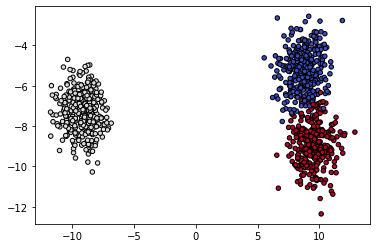

In [79]:
plt.scatter(X[:,0],X[:,1],c=y,cmap=plt.cm.coolwarm,s=20,edgecolors='k')

In [80]:
#이 상태에서 가우시안
model = GaussianNB()
model.fit(X,y)

GaussianNB()

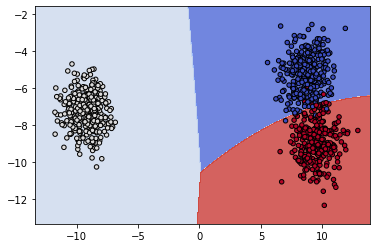

In [81]:
xx,yy = make_meshgrid(X[:,],X[:,1])
plot_contours(model,xx,yy,cmap=plt.cm.coolwarm,alpha=0.8)
plt.scatter(X[:,0],X[:,1],c=y,cmap=plt.cm.coolwarm,s=20,edgecolors='k')

## 베르누이 나이브 베이즈

* 입력 특성이 베르누이 분포에 의해 생성된 이진 값을 갖는 다고 가정

### 학습 및 평가 (Count)

### 학습 및 평가 (Hash)

### 학습 및 평가 (Tf-idf)

### 시각화

## 다항 나이브 베이즈

* 입력 특성이 다항분포에 의해 생성된 빈도수 값을 갖는 다고 가정

### 학습 및 평가 (Count)

### 학습 및 평가 (Tf-idf)

### 시각화